## Import necessary packages

In [623]:
#Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error

 ## Import cleaned datasets 

In [624]:
#Import user_ratings
user_ratings = pd.read_csv('./clean_data/user_ratings_clean.csv')

In [625]:
#Import cleaned movie_data 
movie_data = pd.read_csv('./clean_data/movie_data_clean.csv')

## General Review of Each Imported Dataset

In [626]:
#Check 1st few observations of user ratings
user_ratings.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story
1,5,1,4.0,Toy Story
2,7,1,4.5,Toy Story
3,15,1,2.5,Toy Story
4,17,1,4.5,Toy Story


In [627]:
#Check 1st few observations for movie_data
movie_data.head()

,title,overview,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...",1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Jumanji,When siblings Judy and Peter discover an encha...,2,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,3,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",4,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,5,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [628]:
#Check for null observations - user_ratings
user_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73503 entries, 0 to 73502
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   73503 non-null  int64  
 1   movieId  73503 non-null  int64  
 2   rating   73503 non-null  float64
 3   title    73503 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 2.2+ MB


In [629]:
#Check for null observations - movie_data
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6917 entries, 0 to 6916
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               6917 non-null   object
 1   overview            6917 non-null   object
 2   movieId             6917 non-null   int64 
 3   (no genres listed)  6917 non-null   int64 
 4   Action              6917 non-null   int64 
 5   Adventure           6917 non-null   int64 
 6   Animation           6917 non-null   int64 
 7   Children            6917 non-null   int64 
 8   Comedy              6917 non-null   int64 
 9   Crime               6917 non-null   int64 
 10  Documentary         6917 non-null   int64 
 11  Drama               6917 non-null   int64 
 12  Fantasy             6917 non-null   int64 
 13  Film-Noir           6917 non-null   int64 
 14  Horror              6917 non-null   int64 
 15  IMAX                6917 non-null   int64 
 16  Musical             6917

## Non-personalized recommendations

**Movies with Greatest Number of Reviews**

This initial non-personalized recommendation will review the movies with the greatest number of reviews in the user ratings data. No consideration is being given to the numeric ratings of these movies, only the frequency with which they've been reviewed.

In [630]:
#Create a function to review top-10 movies with most reviews
def movies_most_reviews(user_ratings):
    
    #Count the reviews per movie title, sorts automatically in descending order
    movie_popularity = user_ratings['title'].value_counts()
    
    #Return observations with top-10 # of reviews from this df
    return movie_popularity.head(10).index

In [631]:
#Run function to return top-10 movies with most user ratings
movies_most_reviews(user_ratings)

Index(['Forrest Gump', 'Pulp Fiction', 'Jurassic Park', 'Braveheart',
       'Terminator 2: Judgment Day', 'Schindler's List', 'Fight Club',
       'Toy Story', 'American Beauty', 'Seven'],
      dtype='object', name='title')

**Movies with Highest Average Rating**

The last impersonalized recommendation method had clear faults, it didn't even consider the numeric user ratings. It operated under the assumption that if a movie occurred more frequently in the user ratings dataset (i.e. it had been watched by more people) it was better and this isn't necessarily true. 

Here we will look at the highest average mean ratings for titles in the user ratings dataset.

In [632]:
#Create a function to review top-10 movies with highest average ratings
def movies_highest_avg_rating(user_ratings):
    
    #Group user ratings titles/ratings by title & take average rating per film
    average_rating_df = user_ratings[["title", "rating"]].groupby('title').mean()
    
    #Sort average ratings in descending order
    sorted_average_rating_df = average_rating_df.sort_values(by = "rating", ascending = False)
    
    #Return top-10 movies with highest average rating
    return sorted_average_rating_df.head(10).index

In [633]:
#Run function to return top-10 movies with highest average ratings
movies_highest_avg_rating(user_ratings)

Index(['Going Places', 'Moonlight', 'Shogun Assassin', 'Happy Feet Two',
       'My Love', 'My Life as McDull', 'My Left Eye Sees Ghosts',
       'Tickling Giants', 'Harlan County U.S.A.', 'Siam Sunset'],
      dtype='object', name='title')

**Movies with Greater than 50 Reviews with Highest Average Rating**

Reviewing movies by highest average rating is an improvement, but by only reviewing by highest average rating- this doesn't account for movie titles where only 1 user may have watched it and really enjoyed the movie. Therefore, the high rating may driven by there only being one enthusiastic viewer of that movie. 

To improve upon this, we will look at the highest average ratings in the dataset of movies that have been reviewed by at least 50 viewers. This helps to ensure that movies with the highest average ratings likely have broader appeal and truly are well-liked by the public.

In [634]:
#Create a function to review top-10 movies with highest average rating that have 50+ reviews
def movies_highest_avg_rating_50_plus_reviews(user_ratings):
    
    #Count the reviews per movie title, sorts automatically in descending order
    movie_popularity = user_ratings["title"].value_counts()
    
    #Filter for movies with greater than 50 reviews
    popular_movies = movie_popularity[movie_popularity > 50].index
    
    #Filter user ratings df for only movies that have more than 50 reviews
    popular_movies_rankings = user_ratings[user_ratings["title"].isin(popular_movies)]
    
    #Sort the movies that have at least 50 reviews by title & take average rating
    popular_movies_average_rankings = popular_movies_rankings[["title", "rating"]].groupby('title').mean()
    
    #Sort the average ratings of movies with at least 50 reviews in descending order by rating
    sorted_popular_movies_rankings = popular_movies_average_rankings.sort_values(by = 'rating', ascending = False)
    
    return sorted_popular_movies_rankings.head(10).index

In [635]:
#Run function to determine top-10 movies with highest average ratings that have at least 50 reviews
movies_highest_avg_rating_50_plus_reviews(user_ratings)

Index(['Fight Club', 'Cool Hand Luke',
       'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb',
       'Rear Window', 'Casablanca', 'Schindler's List', 'Apocalypse Now',
       'American History X', 'Chinatown', 'Raiders of the Lost Ark'],
      dtype='object', name='title')

**Movies Commonly Viewed By the Same Person Together**

So far we have been looking at movies in isolation, it may be helpful to expand upon this and review movies that are commonly viewed by the same user together. This helps to cater recommendations more specifically to users based on the preferences of other users who are assumed to be similar based on their movie-watching history.

In [636]:
#Create a function to find permutations in dataset
def create_pairs(x):
    pairs = pd.DataFrame(list(permutations(x.values, 2)), columns = ['movie_a', 'movie_b'])
    return pairs

In [637]:
#Create function to find top-10 most commonly viewed movie pairs in the user ratings data
def common_pair_movies(user_ratings, movie_name):
    
    #Apply create_pairs function to user_ratings
    movie_pairs = user_ratings.groupby('userId')['title'].apply(create_pairs)
    
    #Drop the userId index
    movie_pairs_names = movie_pairs.reset_index(drop = True)
    
    #Review how frequently each pair occurs
    movie_pair_names_counts = movie_pairs_names.groupby(['movie_a', 'movie_b']).size()
    
    #Convert movie_pairs_counts to dataframe 
    movie_pair_counts_df = movie_pair_counts.to_frame(name = 'size').reset_index()
    
    #Sort movie_pair_counts_df
    sorted_counts_df = movie_pair_counts_df.sort_values(by = 'size', ascending = False)
    
    #Find the most frequently pair movies by filtering by for a specific title, movie_name
    movie_name_counts = sorted_counts_df[sorted_counts_df['movie_a'] == movie_name]
    
    #Top ten movies seen with movie_name
    movie_name_counts_top10 = movie_name_counts.head(10)
    
    #Create a plot of most commonly viewed movies with The Shawshank Redemption
    movie_name_counts_top10.plot.bar(x = 'movie_b')
    
    return movie_name_counts_top10

,movie_a,movie_b,size
19868737,"Shawshank Redemption, The",Forrest Gump,231
19871837,"Shawshank Redemption, The",Pulp Fiction,222
19872537,"Shawshank Redemption, The","Silence of the Lambs, The",199
19870697,"Shawshank Redemption, The","Matrix, The",181
19867221,"Shawshank Redemption, The",Braveheart,167
19872310,"Shawshank Redemption, The",Schindler's List,165
19873746,"Shawshank Redemption, The","Usual Suspects, The",163
19868614,"Shawshank Redemption, The",Fight Club,162
19872813,"Shawshank Redemption, The",Star Wars: Episode IV - A New Hope,156
19869992,"Shawshank Redemption, The",Jurassic Park,154


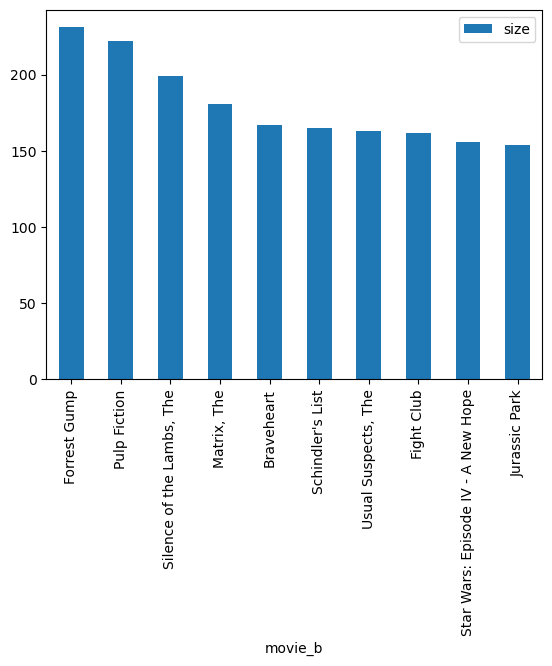

In [638]:
#Find 10-most common movies viewed by users who have seen 'The Shawshank Redemption'
common_pair_movies(user_ratings, 'Shawshank Redemption, The')

,movie_a,movie_b,size
12100115,Jurassic Park,Forrest Gump,198
12103246,Jurassic Park,Pulp Fiction,173
12104565,Jurassic Park,Terminator 2: Judgment Day,167
12098541,Jurassic Park,Braveheart,161
12103966,Jurassic Park,"Silence of the Lambs, The",157
12103887,Jurassic Park,"Shawshank Redemption, The",154
12098095,Jurassic Park,Batman,145
12100216,Jurassic Park,"Fugitive, The",145
12101103,Jurassic Park,Independence Day,144
12104244,Jurassic Park,Star Wars: Episode IV - A New Hope,140


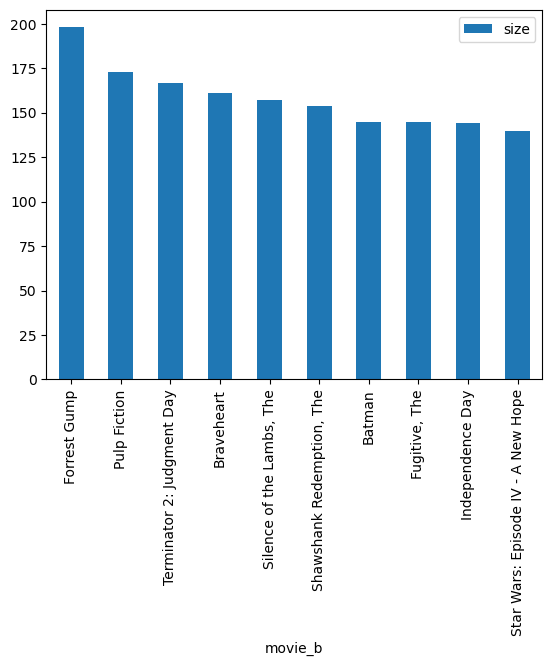

In [639]:
#Repeat for 'Jurassic Park'
common_pair_movies(user_ratings, 'Jurassic Park')

## Comparison between Item-based Recommendations & User-based Recommendations


**Item-based recommendations**

**Pros:** <br>
-More consistent over time (i.e. user preferences may change) <br> 
-Easier to explain (based on content of an item, easier for a person to rationalize vs the preferences of another user they may have never met before) <br> 
-Can be pre-calculated by using inventory data, which is generally more static (new users may constantly appear and it is more challenging to keep user-based data current) <br>

<br>

**Cons:** <br>
-Can be obvious suggestions (i.e. not helpful to suggest another movie in the same series etc.)
 <br>

**User-based recommendations**

**Pros:** <br>
-Can create more unexpected suggestions
<br>
<br>
**Cons:** <br>
-Item-based recommendations typically are superior when compared using standard metrics

## Recommendations based on Movie Attributes

**Creation of Movie_Genres df**

In [640]:
#Review movie_data using .info()
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6917 entries, 0 to 6916
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               6917 non-null   object
 1   overview            6917 non-null   object
 2   movieId             6917 non-null   int64 
 3   (no genres listed)  6917 non-null   int64 
 4   Action              6917 non-null   int64 
 5   Adventure           6917 non-null   int64 
 6   Animation           6917 non-null   int64 
 7   Children            6917 non-null   int64 
 8   Comedy              6917 non-null   int64 
 9   Crime               6917 non-null   int64 
 10  Documentary         6917 non-null   int64 
 11  Drama               6917 non-null   int64 
 12  Fantasy             6917 non-null   int64 
 13  Film-Noir           6917 non-null   int64 
 14  Horror              6917 non-null   int64 
 15  IMAX                6917 non-null   int64 
 16  Musical             6917

In [641]:
#Review movie_data using .head()
movie_data.head()

,title,overview,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...",1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Jumanji,When siblings Judy and Peter discover an encha...,2,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,3,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",4,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,5,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [642]:
#Create a dataframe with just movie title & genre columns
movies_genres = movie_data.drop(columns = ['overview'])

In [643]:
#Review first few observations of the new movies_genres df
movies_genres.head()

,title,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,Toy Story,1,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Jumanji,2,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Grumpier Old Men,3,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,Waiting to Exhale,4,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Father of the Bride Part II,5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [644]:
#Review the shape of the movies_genres df
movies_genres.shape

(6917, 22)

In [645]:
#Review datatypes of each column
movies_genres.dtypes

title                 object
movieId                int64
(no genres listed)     int64
Action                 int64
Adventure              int64
Animation              int64
Children               int64
Comedy                 int64
Crime                  int64
Documentary            int64
Drama                  int64
Fantasy                int64
Film-Noir              int64
Horror                 int64
IMAX                   int64
Musical                int64
Mystery                int64
Romance                int64
Sci-Fi                 int64
Thriller               int64
War                    int64
Western                int64
dtype: object

In [646]:
#Reset the index of movie_genres df to movie names

In [647]:
#Create a list for all movie titles- movies
movies = movies_genres['title'].values

In [648]:
#Inspect movies
print(movies)

['Toy Story' 'Jumanji' 'Grumpier Old Men' ...
 'Self-criticism of a Bourgeois Dog' 'Der Herr Karl'
 'LEGO DC Super Hero Girls: Brain Drain']


In [649]:
#Create a dataframe containing movie names as indices & genres as columns
movie_index_genres = pd.DataFrame(movies_genres.iloc[:, 2:23])
movie_index_genres.set_index(movies, inplace = True, drop = True)

In [650]:
#Inspect new dataframe
movie_index_genres

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
Toy Story,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Jumanji,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Grumpier Old Men,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Waiting to Exhale,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
Father of the Bride Part II,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Themroc,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
A German Life,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Self-criticism of a Bourgeois Dog,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Der Herr Karl,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Jaccard Similarity Scores Using Movie Genre Data**

In generating user recommendations for movies to view, it could be helpful to quantify how similar 2 movies are to one another. A method to do this is using the Jaccard Similarity Score.

The Jaccard similarity score is a statistic to measure the similarity between two data sets. It is measured as the size of the intersection of two sets divided by the size of their union. As shown below. It is a useful similarity metric to use when comparing similarity between 2 sets - like genre classifications for 2 different movies. It takes values between 0 and 1, where 0 is the least similar and 1 is the most similar.

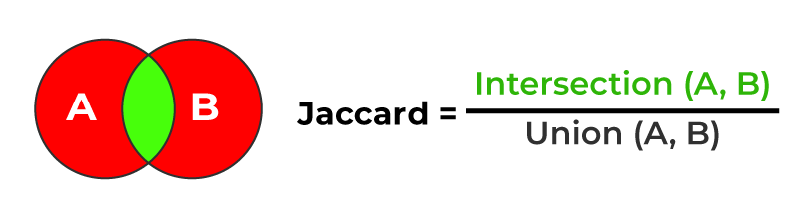

In [651]:
#Calculating the Jaccard similarity score for 2 movies- 'Toy Story' & 'Jumanji'

#Select category attributes for each movie
toy_story_row = movie_index_genres.loc['Toy Story', :]
jumanji_row = movie_index_genres.loc['Jumanji', :]

In [652]:
#Calculate Jaccard similarity score between Toy Story & Jumanji
jaccard_score(toy_story_row, jumanji_row, average = 'binary')

0.6

In [653]:
#More useful to be able to review Jaccard similarity scores between any 2 movies in df

#Finding the distance between all movies in the dataframe
jaccard_distances = pdist(movie_index_genres.values, metric = 'jaccard')

In [654]:
#Inspect jaccard_distances & its shape
print(jaccard_distances)
print(jaccard_distances.shape)

[0.4        0.83333333 0.85714286 ... 0.         1.         1.        ]
(23918986,)


In [655]:
#Square the jaccard distances
square_jaccard_distances = squareform(jaccard_distances)

In [656]:
#Inspect square_jaccard_distances & its shape
#Dimensions should be # of movies in original df x # of movies in original df
print(square_jaccard_distances)
print(square_jaccard_distances.shape)

[[0.         0.4        0.83333333 ... 0.8        0.8        0.8       ]
 [0.4        0.         1.         ... 1.         1.         1.        ]
 [0.83333333 1.         0.         ... 0.5        0.5        1.        ]
 ...
 [0.8        1.         0.5        ... 0.         0.         1.        ]
 [0.8        1.         0.5        ... 0.         0.         1.        ]
 [0.8        1.         1.         ... 1.         1.         0.        ]]
(6917, 6917)


In [657]:
#Square_jaccard_distances gives us the differences between each attribute
#To get the similarity per attribute you can take this & subtract from 1
jaccard_similarity_array = 1 - square_jaccard_distances

In [658]:
#Inspect jaccard_similarity_array & its shape
print(jaccard_similarity_array)
print(jaccard_similarity_array.shape)

[[1.         0.6        0.16666667 ... 0.2        0.2        0.2       ]
 [0.6        1.         0.         ... 0.         0.         0.        ]
 [0.16666667 0.         1.         ... 0.5        0.5        0.        ]
 ...
 [0.2        0.         0.5        ... 1.         1.         0.        ]
 [0.2        0.         0.5        ... 1.         1.         0.        ]
 [0.2        0.         0.         ... 0.         0.         1.        ]]
(6917, 6917)


In [659]:
#Put the jaccard_similarity_array into a dataframe
distance_df = pd.DataFrame(jaccard_similarity_array, index = movies, columns = movies)

In [660]:
#Check the 1st few observations
distance_df.head()

,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,The Emoji Movie,Wind River,Rory Scovel Tries Stand-Up for the First Time,Shot Caller,Rick and Morty: State of Georgia Vs. Denver Fenton Allen,Themroc,A German Life,Self-criticism of a Bourgeois Dog,Der Herr Karl,LEGO DC Super Hero Girls: Brain Drain
Toy Story,1.000000,0.6,0.166667,0.142857,0.200000,0.0,0.166667,0.400000,0.0,0.142857,...,0.600000,0.0,0.200000,0.000000,0.166667,0.166667,0.0,0.200000,0.200000,0.2
Jumanji,0.600000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.666667,0.0,0.200000,...,0.200000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
Grumpier Old Men,0.166667,0.0,1.000000,0.666667,0.500000,0.0,1.000000,0.000000,0.0,0.000000,...,0.250000,0.0,0.500000,0.000000,0.333333,0.333333,0.0,0.500000,0.500000,0.0
Waiting to Exhale,0.142857,0.0,0.666667,1.000000,0.333333,0.0,0.666667,0.000000,0.0,0.000000,...,0.200000,0.0,0.333333,0.166667,0.250000,0.250000,0.0,0.333333,0.333333,0.0
Father of the Bride Part II,0.200000,0.0,0.500000,0.333333,1.000000,0.0,0.500000,0.000000,0.0,0.000000,...,0.333333,0.0,1.000000,0.000000,0.500000,0.500000,0.0,1.000000,1.000000,0.0


In [661]:
#Compare jaccard_similarity_scores any 2 movies 
def jaccard_similarity_scores_genres(df, movie_1, movie_2):
    
    #Return relevant observation from distance_df
    return distance_df[movie_1][movie_2]

In [662]:
#Check jaccard_similarity score between 2 similar movies

#Comparing two similar movies- like 'GoldenEye' & 'Skyfall' (both James Bond, action movies), should yield a similarity score near 1
jaccard_similarity_scores_genres(distance_df, 'GoldenEye', 'Skyfall')

0.75

In [663]:
#Check jaccard_similarity score between 2 dissimilar movies

#Comparing 2 dissimilar movies- like 'Toy Story' & 'GoldenEye' (1 is children's movie, 1 is James Bond action movie), should yield a low similarity score close to 0
jaccard_similarity_scores_genres(distance_df, 'Toy Story', 'GoldenEye')

0.1428571428571429

In [664]:
#Review top-10 jaccard_similarity scores based on 1 film title
def top_jaccard_similarity_scores_genre_by_movie(df, movie_1):
    
    #Return sorted top-10 movies with highest Jaccard similarity scores based on movie genres info
    movie_1_similarities = distance_df.loc[movie_1].sort_values(ascending = False)
    
    return movie_1_similarities.head(10)

In [665]:
#Review bottom-10 jaccard_similarity scores based on 1 film title
def bottom_jaccard_similarity_scores_genre_by_movie(df, movie_1):
    
    #Return sorted top-10 movies with highest Jaccard similarity scores based on movie genres info
    movie_1_similarities = distance_df.loc[movie_1].sort_values(ascending = False)
    
    return movie_1_similarities.tail(10)

In [666]:
#Review top-10 jaccard similarity scores for 'Thor'
top_jaccard_similarity_scores_genre_by_movie(distance_df, 'Thor')

Thor                                            1.000000
Harry Potter and the Deathly Hallows: Part 2    0.833333
Beowulf & Grendel                               0.800000
Thor: The Dark World                            0.800000
Wrath of the Titans                             0.800000
In the Name of the King III                     0.800000
Harry Potter and the Deathly Hallows: Part 1    0.800000
Harry Potter and the Order of the Phoenix       0.800000
Pirates of the Caribbean: On Stranger Tides     0.800000
Where the Wild Things Are                       0.666667
Name: Thor, dtype: float64

In [667]:
#Review bottom-10 jaccard similarity scores for 'Thor'
bottom_jaccard_similarity_scores_genre_by_movie(distance_df, 'Thor')

This Island Earth                                    0.0
Arsenic and Old Lace                                 0.0
Samsara                                              0.0
Please Don't Eat the Daisies                         0.0
Fear X                                               0.0
Silent Movie                                         0.0
Comandante                                           0.0
M                                                    0.0
Manufacturing Consent: Noam Chomsky and the Media    0.0
LEGO DC Super Hero Girls: Brain Drain                0.0
Name: Thor, dtype: float64

**TF-IDF & Cosine Similarity using Movie Overview Text Data**

Another comparison that we can use for 2 films is using the movie overview data. To start this comparison, we will employ TF-IDF. This technique that can be useful in text applications. It is equal to the expression below and is useful because as the formula demonstrates it reduces the weight of common words that occur in many documents and increases the weight of words that do not occur in many documents. 

We can use this technique to measure how important a term is within a movie text overview vs the entire set of movie text overviews. 

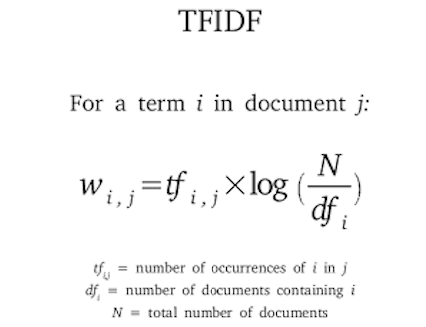

In [668]:
#min_df argument specifies minimum occurence words must appear to be counted
#max_df argument specifies maximum % occurence that words can have to be counted
#i.e. if word appears too frequently it will not be helpful in analysis 
tfidfvec = TfidfVectorizer(min_df = 2, max_df = 0.7)

In [669]:
vectorized_data = tfidfvec.fit_transform(movie_data['overview'])
print(tfidfvec.get_feature_names)

<bound method CountVectorizer.get_feature_names of TfidfVectorizer(max_df=0.7, min_df=2)>


In [670]:
#Row for each movie & column for each feature or word
print(vectorized_data.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [671]:
#Put vectorized data into a dataframe
tfidf_df = pd.DataFrame(vectorized_data.toarray(), index = movie_data['title'].values, columns = tfidfvec.get_feature_names_out())

In [672]:
tfidf_df

,00,000,007,10,100,1000,101,10th,11,119,...,zombies,zone,zones,zoo,zooey,zookeeper,zoologists,zoom,émigré,ôtomo
Toy Story,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jumanji,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grumpier Old Men,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Waiting to Exhale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Father of the Bride Part II,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Themroc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A German Life,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Self-criticism of a Bourgeois Dog,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Der Herr Karl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cosine similarity measures the similarity between two vectors of an inner product space. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction. It is often used to measure document similarity in text analysis as it is a helpful similarity metric to use when items have more variation in their data, which is what we are doing in this case with our TF-IDF data.

A larger values indicates high similarity whereas a lower value indicates low similarity.

In [673]:
#Find the cosine similarity between all items
cosine_similarity_array = cosine_similarity(tfidf_df)

In [674]:
#Create cosine_similarity_df where movie names are indices & rows to assess similarity between movies
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index = tfidf_df.index, columns = tfidf_df.index)

In [675]:
#Review cosine_similarity_df
cosine_similarity_df.head()

,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,The Emoji Movie,Wind River,Rory Scovel Tries Stand-Up for the First Time,Shot Caller,Rick and Morty: State of Georgia Vs. Denver Fenton Allen,Themroc,A German Life,Self-criticism of a Bourgeois Dog,Der Herr Karl,LEGO DC Super Hero Girls: Brain Drain
Toy Story,1.000000,0.028211,0.007362,0.007908,0.024883,0.009041,0.008757,0.002473,0.014257,0.004887,...,0.000000,0.000000,0.004056,0.009714,0.004157,0.005038,0.005435,0.005759,0.0,0.024863
Jumanji,0.028211,1.000000,0.049618,0.028168,0.028931,0.064192,0.015110,0.006563,0.104363,0.005707,...,0.000000,0.095893,0.005743,0.002948,0.009895,0.023953,0.042561,0.006726,0.0,0.035265
Grumpier Old Men,0.007362,0.049618,1.000000,0.037390,0.050339,0.002835,0.005083,0.020820,0.008751,0.000000,...,0.000000,0.004019,0.004793,0.006560,0.004913,0.007758,0.036282,0.000000,0.0,0.008019
Waiting to Exhale,0.007908,0.028168,0.037390,1.000000,0.013877,0.027460,0.013899,0.010186,0.000000,0.011851,...,0.038853,0.013128,0.000000,0.011687,0.006530,0.012508,0.036226,0.000000,0.0,0.014701
Father of the Bride Part II,0.024883,0.028931,0.050339,0.013877,1.000000,0.008182,0.046625,0.011611,0.040318,0.012374,...,0.008929,0.039487,0.040086,0.020662,0.000000,0.029451,0.056966,0.042721,0.0,0.039263


In [676]:
#Define function to find top-10 most similar movies based on cosine similarities
#derivd from plot overview text data between a specific movie & all other movies in the dataset as shown below
def top_10_plot_overview_similarity(df, movie_name):
    
    #Find cosine similarities based on overview text data similarity for movie_name
    movie_name_cosine_sims = df.loc[movie_name]
    
    #Sort cosine similarities for specified movie in descending order
    sorted_movie_name_cosine_sims = movie_name_cosine_sims.sort_values(ascending = False)
    
    #Return top-10 highest cosine similarity films 
    return sorted_movie_name_cosine_sims.head(10)

In [677]:
#Define function to find bottom-10 most similar movies based on cosine similarities
#derivd from plot overview text data between a specific movie & all other movies in the dataset as shown below
def bottom_10_plot_overview_similarity(df, movie_name):
    
    #Find cosine similarities based on overview text data similarity for movie_name
    movie_name_cosine_sims = df.loc[movie_name]
    
    #Sort cosine similarities for specified movie in descending order
    sorted_movie_name_cosine_sims = movie_name_cosine_sims.sort_values(ascending = False)
    
    #Return top-10 highest cosine similarity films 
    return sorted_movie_name_cosine_sims.tail(10)

In [678]:
#Find top-10 films with highest cosine similarities based on plot overview text data for 'Father of the Bride Part II'
top_10_plot_overview_similarity(cosine_similarity_df, 'Father of the Bride Part II')

Father of the Bride Part II    1.000000
Kuffs                          0.316884
Wendigo                        0.280507
It's a Wonderful Life          0.263981
Junebug                        0.250013
George of the Jungle           0.232296
Blow                           0.228072
Funny People                   0.227445
Hollywoodland                  0.198321
Autumn Marathon                0.193934
Name: Father of the Bride Part II, dtype: float64

In [679]:
#Find bottom-10 films with highest cosine similarities based on plot overview text data for 'Father of the Bride Part II'
bottom_10_plot_overview_similarity(cosine_similarity_df, 'Father of the Bride Part II')

Once Upon a Time in China    0.0
Feast                        0.0
Pawn Sacrifice               0.0
Spotlight                    0.0
Beyond Bedlam                0.0
The Editor                   0.0
Far from Heaven              0.0
Natural Born Killers         0.0
Femme Fatale                 0.0
Kelly's Heroes               0.0
Name: Father of the Bride Part II, dtype: float64

## Recommendations based on User Preferences

**Use TF-IDF data to Generate User Profile Recommendations**

Our previous work has been related to item-item recommendations. 

We can expand upon this by using the tfidf_df previously created based on movie plot overviews to review the preferences of a specific user in our dataset so we can see what terms are commonly in movies that user has reviewed.

In [680]:
#Create a function to determine top-10 user profile preferences for a generic user
def top_10_user_prof(user_Id): 
    
    #Extract ratings of a specific user - in this case userId = 5
    user_id_movies = user_ratings[user_ratings['userId'] == user_Id]['title'].values
    
    #Filter movies reviewed by userId = user_Id from tfidf_df 
    user_movies = tfidf_df.loc[tfidf_df.index.isin(user_id_movies)]
    
    #Summarize userId = userId's preferences
    user_prof = user_movies.mean()
    
    #Return preferences of userId = userId
    return user_prof.sort_values(ascending = False).head(10)

In [681]:
#Create a function to determine bottom-10 user profile preferences for a generic user
def bottom_10_user_prof(user_Id): 
    
    #Extract ratings of a specific user - in this case userId = 5
    user_id_movies = user_ratings[user_ratings['userId'] == user_Id]['title'].values
    
    #Filter movies reviewed by userId = user_Id from tfidf_df 
    user_movies = tfidf_df.loc[tfidf_df.index.isin(user_id_movies)]
    
    #Summarize userId = userId's preferences
    user_prof = user_movies.mean()
    
    #Return preferences of userId = userId
    return user_prof.sort_values(ascending = False).tail(10)

In [682]:
#Review userId == 5 top-10 preferences
top_10_user_prof(5)

his     0.046156
in      0.041712
her     0.037180
he      0.032261
with    0.030156
who     0.029611
from    0.029204
is      0.026884
she     0.026050
true    0.026013
dtype: float64

In [683]:
#Review userId == 5 bottom-10 preferences
bottom_10_user_prof(5)

february      0.0
fed           0.0
federal       0.0
federale      0.0
federation    0.0
federico      0.0
feds          0.0
feed          0.0
feeding       0.0
ôtomo         0.0
dtype: float64

In [684]:
#Review userId == 10 preferences
top_10_user_prof(10)

her     0.049412
in      0.041396
his     0.036325
with    0.030772
he      0.029957
is      0.028318
she     0.025226
life    0.024970
that    0.024505
as      0.024110
dtype: float64

In [685]:
#Review userId == 10 bottom-10 preferences
bottom_10_user_prof(10)

flesh       0.0
fletch      0.0
fletcher    0.0
flew        0.0
flight      0.0
flights     0.0
flighty     0.0
flint       0.0
flirt       0.0
ôtomo       0.0
dtype: float64

**Collaborative Filtering Overview**

The rationale behind collaborative filtering is summarized below and in the visual and is relevant when leveraging user ratings data to predict user movie preferences.

If person A has similar tastes to persons B and both person B likes a certain movie, then it is likely that person A will also like that movie.

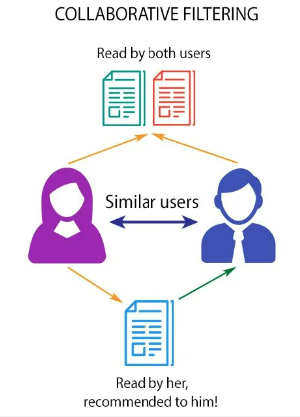

**Pivoting User Ratings Df**

To better facilitate review of user ratings data using collaborative filtering, we can pivot our user ratings dataframe so the indices are the userId values, columns are the movie titles, and the values are the ratings given to each movie by user. We had completed this operation during the EDA and calculated sparsity. Recall that the dataframe was very sparse, about 98% of possible observations were missing. 

In [686]:
#Reshape the user ratings dataframe to get rows containing userIds & columns containing movie titles
user_ratings_pivot = user_ratings.pivot_table(index = 'userId', columns = 'title', values = 'rating', aggfunc = 'mean')

In [687]:
#Review user_ratings_pivot
user_ratings_pivot

title,'71,'Tis the Season for Love,...All the Marbles,...And Justice for All,00 Schneider - Jagd auf Nihil Baxter,1-900,10,10 Cent Pistol,10 Cloverfield Lane,10 Items or Less,...,Zoolander 2,Zoom,Zootopia,Zulu,[REC],[REC]²,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN


The values of ratings imply order- i.e. 0 is a low rating and 5 is a high rating. If we were to fill NaN values present in observations where a user hasn't seen a movie with 0, this would inadvertently imply that a user disliked a movie and this may not true. Since we don't want to inadvertently skew a user's tastes, we will instead center each user's ratings around 0 and then fill missing data with 0s.

In [688]:
#Calculate the average rating for each user (i.e. each row of data)
avg_ratings = user_ratings_pivot.mean(axis = 1)

In [689]:
#Center each user's ratings around 0
user_ratings_pivot_centered = user_ratings_pivot.sub(avg_ratings, axis=0)

In [690]:
#Fill missing data with 0s
user_ratings_pivot_normed = user_ratings_pivot_centered.fillna(0)

In [691]:
#Review user_ratings_pivot_normed 
user_ratings_pivot_normed

title,'71,'Tis the Season for Love,...All the Marbles,...And Justice for All,00 Schneider - Jagd auf Nihil Baxter,1-900,10,10 Cent Pistol,10 Cloverfield Lane,10 Items or Less,...,Zoolander 2,Zoom,Zootopia,Zulu,[REC],[REC]²,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.29697
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
607,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
608,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.422581,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.422581,0.422581,0.000000,0.00000


**Cosine Similarities of User Ratings for Different Movies to Generate Movie Recommendations**

In [692]:
#Create dataframe conducive to item-based recommendation analysis by taking transpose of user_ratings_pivot_normed
movie_ratings_normed = user_ratings_pivot_normed.T

In [693]:
#Review movie_ratings_normed
movie_ratings_normed

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.309845
'Tis the Season for Love,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
...All the Marbles,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
...And Justice for All,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
00 Schneider - Jagd auf Nihil Baxter,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
[REC]²,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,-0.190155
eXistenZ,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,1.515625,0.0,0.0,0.0,0.0,1.422581,0.0,0.000000
xXx,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.060606,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.422581,0.0,-1.690155


In [694]:
#Define a function to find the cosine similarity based on user ratings between any 2 movies in user ratings data
def cosine_sims_2_movies_user_ratings(df, movie_1, movie_2):
    
    #Obtain normalized user rating data for movie_1
    movie_1_user_ratings = movie_ratings_normed.loc[movie_1, :].values.reshape(1,-1)
    
    #Obtain normalized user rating data for movie_2
    movie_2_user_ratings = movie_ratings_normed.loc[movie_2, :].values.reshape(1,-1)
    
    #Calculate & return cosine similarity b/t 2 movies
    return cosine_similarity(movie_1_user_ratings, movie_2_user_ratings)

In [695]:
#Review cosine similarities between 2 similar films 'GoldenEye' & 'Skyfall'
cosine_sims_2_movies_user_ratings(movie_ratings_normed, 'GoldenEye', 'Skyfall')

array([[0.10622768]])

In [696]:
#Repeat exercise using 2 movies that are very dissimilar - 'Jurassic Park' & 'Pulp Fiction'
#Cosine similarity should be closer to -1
cosine_sims_2_movies_user_ratings(movie_ratings_normed, 'Jurassic Park', 'Pulp Fiction')

array([[0.04620683]])

In [697]:
#Find the cosine similarities between movies using all user ratings at once
similarities_all_movies_user_reviews = cosine_similarity(movie_ratings_normed)

In [698]:
#Wrap the cosine similarities into a dataframe
#Now you can see how similar movies are to each other based on user ratings
cosine_similarity_df_user_reviews = pd.DataFrame(similarities_all_movies_user_reviews, index = movie_ratings_normed.index, columns = movie_ratings_normed.index)

In [699]:
#Review top-10 cosine similarities per film based on user ratings
def top_10_cosine_sims_user_ratings(movie_1):
    
    #Obtain observation related to this movie from cosine_similarity_df_user_reviews df
    return cosine_similarity_df_user_reviews.loc[movie_1].sort_values(ascending = False).head(10)

In [700]:
#See top 10 related movies based on cosine similarities of user review data for 'xXx'
top_10_cosine_sims_user_ratings('xXx')

title
xXx                                      1.000000
Adanggaman                               0.548417
Rugrats in Paris: The Movie              0.532595
xXx: State of the Union                  0.490259
Tom and Huck                             0.478910
Spy Kids 2: The Island of Lost Dreams    0.465349
Kill Command                             0.463817
Taken 3                                  0.451834
Taken 2                                  0.436828
Lara Croft: Tomb Raider                  0.433280
Name: xXx, dtype: float64

In [701]:
#Review bottom-10 cosine similarities per film based on user ratings
def bottom_10_cosine_sims_user_ratings(movie_1):
    
    #Obtain observation related to this movie from cosine_similarity_df_user_reviews df
    return cosine_similarity_df_user_reviews.loc[movie_1].sort_values(ascending = False).tail(10)

In [702]:
#See bottom 10 related movies based on cosine similarities of user review data for 'xXx'
bottom_10_cosine_sims_user_ratings('xXx')

title
Stone               -0.374954
[REC]               -0.380923
Killing Me Softly   -0.387593
Peaceful Warrior    -0.387593
Eden Lake           -0.387593
Helen of Troy       -0.387593
Sin Nombre          -0.387593
Cats Don't Dance    -0.388677
Soft Fruit          -0.548417
Kiss Me Kate        -0.548417
Name: xXx, dtype: float64

**K-Nearest Neighbors based on User Ratings for Movies for Movie Rating Prediction**

Predict how a user might rate an item even if the item is not similar to an item the user has previously seen

Find similar users using a K-Nearest neighbors model and see how they liked the item.

KNN finds the k users that are closest measured by a specific metric, to the user in question. Then it averages the rating those users gave the item we are trying to get a rating for. Allows us to predict how a user may feel about an item even if the user hasn't seen the item before.

In [703]:
#Construct cosine similarities df for user-user similarities
user_user_similarities = cosine_similarity(user_ratings_pivot_normed)

#Put user-user similarities into a df
user_user_similarities_df = pd.DataFrame(user_user_similarities, index = user_ratings_pivot_normed.index, columns = user_ratings_pivot_normed.index)

In [704]:
#Review user_user_similarities_df
user_user_similarities_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000885,-0.002738,0.043485,0.025535,-0.051829,-0.034640,0.043288,0.035603,-0.001087,...,0.003418,-0.023600,-0.024345,-0.046457,-0.032024,0.019645,0.040796,0.053704,-0.065949,0.004706
2,0.000885,1.000000,0.000000,-0.021403,0.000000,0.000713,-0.013690,0.000000,0.000000,0.064927,...,-0.038115,0.000000,-0.002174,0.000000,0.000000,0.006093,0.000000,0.003731,0.000000,0.017762
3,-0.002738,0.000000,1.000000,-0.014703,-0.036882,0.005343,0.000000,-0.049048,0.000000,0.000000,...,-0.011301,-0.021045,0.011569,0.000000,-0.001733,-0.046031,-0.012392,-0.018215,0.000000,0.012077
4,0.043485,-0.021403,-0.014703,1.000000,-0.031634,-0.007471,0.027887,-0.016328,-0.007991,0.040262,...,-0.044346,0.007732,0.036728,-0.036919,0.036724,0.025203,0.003465,-0.036095,-0.062812,-0.012844
5,0.025535,0.000000,-0.036882,-0.031634,1.000000,0.038697,0.010210,0.056268,0.000000,-0.041866,...,0.030164,0.004792,0.034145,0.050020,-0.049326,0.033920,0.042873,0.006983,0.196188,-0.004814


In [705]:
#User-based dataframe with center values
user_ratings_pivot_normed.head()

title,'71,'Tis the Season for Love,...All the Marbles,...And Justice for All,00 Schneider - Jagd auf Nihil Baxter,1-900,10,10 Cent Pistol,10 Cloverfield Lane,10 Items or Less,...,Zoolander 2,Zoom,Zootopia,Zulu,[REC],[REC]²,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.29697
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000


In [706]:
#User-based dataframe with uncentered scores & missing values
user_ratings_pivot.head()

title,'71,'Tis the Season for Love,...All the Marbles,...And Justice for All,00 Schneider - Jagd auf Nihil Baxter,1-900,10,10 Cent Pistol,10 Cloverfield Lane,10 Items or Less,...,Zoolander 2,Zoom,Zootopia,Zulu,[REC],[REC]²,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [707]:
#Review user ratings for 'Waiting to Exhale'
waiting_to_exhale = user_ratings_pivot.loc[:, 'Waiting to Exhale']

In [708]:
#Review users that have rated movie 'Waiting to Exhale'
waiting_to_exhale

userId
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
       ..
606   NaN
607   NaN
608   NaN
609   NaN
610   NaN
Name: Waiting to Exhale, Length: 610, dtype: float64

In [709]:
#Create a function that specifies the userId number, movie title, KNeighborsRegressor() parameters that you would like to use
#to predict a movie rating
#Movie rating will be derived from specified nearest neighbor user rating preferences

def KNN_Regressor_user_rating_pred(userId, movie_name, n_neighbors):
    
    #Drop the movie ratings you are trying to predict 
    #i.e. 'movie_name' column in the centered, filled with zeroes df
    other_movies_ratings = user_ratings_pivot_normed.drop(movie_name, axis = 1)
    
    #Get the data for the user you are trying to predict the outcome for  
    # i.e. all normalized, centered ratings associated with userId == userId, excluding their 'movie_name' rating
    target_user_x = other_movies_ratings.loc[[userId]]
    
    #Get the target movie user ratings data from the raw user ratings table 
    #i.e. 'movie_name' ratings for all users, these values are raw values (uncentered, unnormalized ratings)
    other_users_y = user_ratings_pivot[movie_name]
    
    #Drop user ratings data for users that haven't seen 'movie_name'
    #This results in centered, normalized data only from users that have seen 'movie_name'
    other_users_x = other_movies_ratings[other_users_y.notnull()]
    
    #Drop the rows that are empty
    #This results in raw ratings data only from users that have seen 'movie_name'
    other_users_y.dropna(inplace = True)
    
    #Instantiate KNeighbors Regressor
    user_knn = KNeighborsRegressor(metric = 'cosine', n_neighbors = n_neighbors)
    
    #Fit user_knn using other_users_x & other_users_y -i.e. training x & y data
    #other_users_x = centered, normalized ratings data only from users that have seen 'movie_name'
    #other_users_y = uncentered, unnormalized ratings values for all users that have seen 'movie_name'
    user_knn.fit(other_users_x, other_users_y)
    
    #Predict on user values that we are looking to predict
    #target_user_x = all normalized, centered ratings associated with userId == userId
    #Predicts the average rating of nearest neighbors
    return user_knn.predict(target_user_x)

In [710]:
#Predict movie rating if userId == 5 were to watch 'Waiting to Exhale' using n_neighbors = 3
KNN_Regressor_user_rating_pred(5, 'Waiting to Exhale', 3)

array([2.])

In [711]:
#Predict movie rating if userId == 5 were to watch 'Waiting to Exhale' using n_neighbors = 5
KNN_Regressor_user_rating_pred(5, 'Waiting to Exhale', 5)

array([2.1])

In [712]:
#Predict movie rating if userId == 3 were to watch 'Waiting to Exhale' using n_neighbors = 5
KNN_Regressor_user_rating_pred(3, 'Waiting to Exhale', 5)

array([2.3])

It looks like the predicted ratings vary slightly as the number of neighbors increases. Using only the 3 nearest neighbors results in a slightly lower rating (2.0 vs 2.1) than when using 5 nearest neighbors.

**SVD/Matrix Factorization to Predict Movie Ratings using User Ratings for Movies**

As noticed during the data wrangling/EDA step, our user ratings data was very sparse. To combat this we will perform singular value decomposition with Matrix Factorization. This will cause us to loose some information from our original matrix but all values will be filled in for user rating data per movie so it will be more useful to derive user preferences.

In [713]:
#Use matrix factorization to deal with sparsity issue with singular value decompisition (SVD)
#Need to use centered, normalized data
user_ratings_pivot_normed.head()

title,'71,'Tis the Season for Love,...All the Marbles,...And Justice for All,00 Schneider - Jagd auf Nihil Baxter,1-900,10,10 Cent Pistol,10 Cloverfield Lane,10 Items or Less,...,Zoolander 2,Zoom,Zootopia,Zulu,[REC],[REC]²,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.29697
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000


In [714]:
#Applying SVD using default number of features, k =6
#Need to convert normalized ratings df to numpy array or sparse array for this method, dataframe can't be input
U, sigma, Vt = svds(user_ratings_pivot_normed.to_numpy())

In [715]:
#Review each element created via SVD method
print(U)
print(U.shape, '\n')

print(sigma)
print(sigma.shape, '\n')

print(Vt)
print(Vt.shape, '\n')

[[ 2.41054551e-02 -3.93643941e-03  1.51708108e-02  1.40697968e-03
   7.15170127e-03  2.34675530e-02]
 [-1.15202620e-03 -1.09493074e-03 -1.18780277e-03  2.69302843e-03
  -6.98898248e-04 -1.21014791e-04]
 [-6.23178296e-03  1.12304164e-02 -9.34742504e-03 -8.03443160e-03
  -1.12333360e-02 -4.87306542e-03]
 ...
 [-1.47025400e-01 -8.31349624e-02 -2.00685281e-01  8.14712115e-02
   3.57375615e-02  1.35666095e-01]
 [ 3.75900903e-03 -1.83389713e-03 -1.75445648e-03  3.78374460e-03
   2.30571707e-04  3.41035820e-03]
 [-1.11899652e-03  9.26138396e-02 -1.22473272e-01  6.51276033e-02
  -1.12727873e-01  1.70711090e-01]]
(610, 6) 

[31.64019055 33.0516439  34.21506093 36.11490862 38.1215447  64.30884077]
(6,) 

[[-1.09580561e-05  9.07291961e-04 -1.09079141e-04 ... -6.55049533e-03
  -1.68469064e-03 -2.29408317e-03]
 [ 8.68213830e-04  5.07787411e-03 -2.36283299e-04 ...  6.56333306e-03
  -2.68727955e-03 -1.23749283e-02]
 [-1.10909278e-03  2.04751797e-03 -1.76815421e-04 ... -1.19096021e-02
   1.53314561e-0

In [716]:
#Convert sigma into a diagonal matrix
sigma_diag = np.diag(sigma)

#Review sigma diagonal matrix & its shape
print(sigma_diag)
print(sigma_diag.shape, '\n')

[[31.64019055  0.          0.          0.          0.          0.        ]
 [ 0.         33.0516439   0.          0.          0.          0.        ]
 [ 0.          0.         34.21506093  0.          0.          0.        ]
 [ 0.          0.          0.         36.11490862  0.          0.        ]
 [ 0.          0.          0.          0.         38.1215447   0.        ]
 [ 0.          0.          0.          0.          0.         64.30884077]]
(6, 6) 



In [717]:
#Recalculating the original matrix

#1st take dot product of U & sigma matrices
U_sigma = np.dot(U, sigma_diag)

#Then take dot product of U_sigma & Vt
U_sigma_Vt = np.dot(U_sigma, Vt)

#Review results
print(U_sigma_Vt)
print(U_sigma_Vt.shape, '\n')

[[ 3.22872645e-04  1.56399890e-03 -8.61793257e-04 ... -3.35360081e-02
  -6.94432449e-03 -2.32603701e-02]
 [ 8.64078082e-05 -2.45541999e-04  3.60406302e-05 ...  3.06270876e-05
  -1.64311077e-03  1.51762982e-03]
 [ 6.51614121e-04  4.54381882e-06  2.64749229e-04 ... -7.16048808e-03
  -3.77396871e-03  9.47646899e-03]
 ...
 [ 1.28525903e-02 -2.71353377e-02 -1.60618680e-03 ... -2.33782579e-02
  -1.99779714e-01  4.82800557e-03]
 [ 2.61336466e-04 -1.74404333e-04 -7.65313868e-05 ... -4.21386849e-03
  -4.61768239e-03 -1.02002222e-03]
 [ 2.15867875e-02  1.29936182e-03 -2.84228056e-03 ... -3.67692920e-01
  -2.60386070e-01 -1.44116554e-02]]
(610, 6917) 



In [718]:
#Add back the row means that are in the avg_ratings attribute
uncentered_ratings = U_sigma_Vt + avg_ratings.values.reshape(-1,1)

In [719]:
#Create a dataframe for these results
calc_pred_ratings_df = pd.DataFrame(uncentered_ratings, index = user_ratings_pivot_normed.index, columns = user_ratings_pivot_normed.columns)

In [720]:
#Review the recalculated & original dataframes

#Recalculated ratings_df after SVD - much less missing (i.e. less sparsity) data makes them more useful for recommendations
calc_pred_ratings_df

title,'71,'Tis the Season for Love,...All the Marbles,...And Justice for All,00 Schneider - Jagd auf Nihil Baxter,1-900,10,10 Cent Pistol,10 Cloverfield Lane,10 Items or Less,...,Zoolander 2,Zoom,Zootopia,Zulu,[REC],[REC]²,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!
userId,,,,,,,,,,,,,,,,,,,,,
1,4.297293,4.298534,4.296108,4.297609,4.298343,4.297046,4.301887,4.292992,4.296845,4.295768,...,4.288902,4.297030,4.303253,4.294713,4.296555,4.297734,4.311693,4.263434,4.290025,4.273709
2,3.977359,3.977027,3.977309,3.976856,3.977344,3.977264,3.976971,3.977261,3.977686,3.977486,...,3.977380,3.977256,3.976188,3.977619,3.978049,3.976957,3.976907,3.977303,3.975630,3.978790
3,2.403877,2.403230,2.403491,2.410585,2.402440,2.403224,2.405566,2.400714,2.402508,2.403259,...,2.400788,2.403254,2.411823,2.410627,2.407310,2.400830,2.393016,2.396065,2.399452,2.412702
4,3.507286,3.515409,3.508893,3.493447,3.509488,3.509659,3.517298,3.508836,3.499854,3.507577,...,3.503667,3.509820,3.483538,3.489053,3.489873,3.518082,3.535617,3.523178,3.540962,3.479975
5,3.628248,3.629436,3.628218,3.624714,3.629461,3.628588,3.628065,3.630168,3.629033,3.628213,...,3.628466,3.628631,3.621089,3.623123,3.625458,3.630514,3.637260,3.627101,3.629059,3.616927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.644405,3.662298,3.641418,3.601014,3.651976,3.645895,3.637717,3.677080,3.648909,3.646057,...,3.647673,3.646607,3.584337,3.600974,3.620382,3.659702,3.771657,3.653066,3.645436,3.504959
607,3.721607,3.719199,3.721906,3.723549,3.721806,3.721720,3.718196,3.722217,3.724064,3.721736,...,3.725944,3.721588,3.730094,3.723037,3.723436,3.721316,3.715915,3.724977,3.721093,3.727860
608,3.090272,3.050284,3.075813,3.007029,3.084468,3.077202,3.008400,3.117141,3.144519,3.107598,...,3.122770,3.074757,3.166343,3.128370,3.184159,3.031619,3.223283,3.054041,2.877640,3.082247


In [721]:
#Original user ratings data, with no normalization - missing lots of data
user_ratings_pivot

title,'71,'Tis the Season for Love,...All the Marbles,...And Justice for All,00 Schneider - Jagd auf Nihil Baxter,1-900,10,10 Cent Pistol,10 Cloverfield Lane,10 Items or Less,...,Zoolander 2,Zoom,Zootopia,Zulu,[REC],[REC]²,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN


In [722]:
#Use the dataframe created from SVD to find movies that userId == 5 would likely enjoy

#First Sort the ratings of User 5 from high to low
user_5_ratings = calc_pred_ratings_df.loc[5 , :].sort_values(ascending = False)

In [723]:
#Review user_5 sorted ratings
user_5_ratings

title
Schindler's List                             3.776502
Pulp Fiction                                 3.775397
Fargo                                        3.733142
Forrest Gump                                 3.730322
Fight Club                                   3.718490
                                               ...   
Wild Wild West                               3.554301
Mission: Impossible II                       3.541117
Armageddon                                   3.533712
Star Wars: Episode I - The Phantom Menace    3.506255
Independence Day                             3.502495
Name: 5, Length: 6917, dtype: float64

## Comparison of Recommendation Methods using RMSE

Complete a comparison of two different recommendations explored so far using the root mean squared error as the metric.
<br>
<br>
1.) Use predictions for movie ratings based on K-Nearest Neighbors Regressor.
<br>
2.) Use the calculated predictions for movie ratings obtained using matrix factorization/SVD.
<br>
<br>
Compare both of these to the actual ratings values using root mean squared error as metric.

In [724]:
#Define relevant ratings that will be compared for userId = 3, movie == 'Bambi'

KNN_rating = KNN_Regressor_user_rating_pred(3, 'Bambi', 5)

Matrix_Factorization_rating = calc_pred_ratings_df[calc_pred_ratings_df.index == 3]['Bambi'].values

actual_rating = (user_ratings[(user_ratings['userId'] == 3) & (user_ratings['title'] == 'Bambi')]['rating'].values)

In [725]:
#Calculate RMSE for KNN_rating vs actual
print(mean_squared_error(KNN_rating, actual_rating, squared = False))

2.0


In [726]:
#Calculate RMSE for matrix factorization/SVD vs actual
print(mean_squared_error(Matrix_Factorization_rating, actual_rating, squared = False))

1.8984408090138656


This is a small sample obviously, but we had a lower root mean square error when using predicted values based on our matrix factorization/SVD predicted ratings values.

It would be worthwhile for further work trying to optimize our KNN Regressor parameters like trialling different numbers of neighbors to see if more accurate performance could be obtained.

Additionally, for the Matrix Factorization/SVD, we created a matrix with the default number of latent features - k = 6. To optimize agreement between actual and predicted ratings, we could trial making matrices with varying numbers of latent features to see if performance could be improved. 

For now, I would recommend using the Matrix Factorization/SVD predicted ratings data to predict a user's movie prefrences.